<a href="https://colab.research.google.com/github/larrygoyeau/bubble_segmentation_Unet/blob/master/Unet_automatic_segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bubble segementation using Unet: inference model

In [0]:
#@title If you use google colab, first click on "ouvrir en mode brouillon" on the upper panel and run this block (click on this text and Ctrl+Entre). This will install the framwork. { run: "auto" }
%tensorflow_version 1.x
!git clone https://github.com/larrygoyeau/bubble_segmentation_Unet
import sys
sys.path.insert(1, "/content/bubble_segmentation_Unet")
from segementation import *

TensorFlow 1.x selected.
Cloning into 'bubble_segmentation_Unet'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 1012 (delta 44), reused 0 (delta 0), pack-reused 934
Receiving objects: 100% (1012/1012), 338.88 MiB | 32.86 MiB/s, done.
Resolving deltas: 100% (618/618), done.


Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Loaded model from disk


In [0]:
#@title Do you want to remove the bubbles that are in contact with the outline of the images? { run: "auto" }

Select_the_answer_and_run_this_block = 'No' #@param ["Yes", "No"]

if Select_the_answer_and_run_this_block=='Yes':
  remove_bubbles_on_the_border=True
else:
  remove_bubbles_on_the_border=False

Now run the block below. Then click on “select fichiers” and select (several) images that you want to segment from your device. The segmented images are saved on the left panel 'fichier'. Click on 'actualliser' and the file will appear. These files are:


*   mask_plus_image_name.png $ $ $ $ for the segmentation plus the image
*   mask_of_image_name.png $ $ $ $ for the mask only
* image_name.txt $ $ $ $ for the description of each bubble detected on the image



 You can download them by right clicking on them and select 'telecharger'. If you get an error run once again or tell me.


Saving photo 15.png to photo 15.png


Number of detected bubbles 200


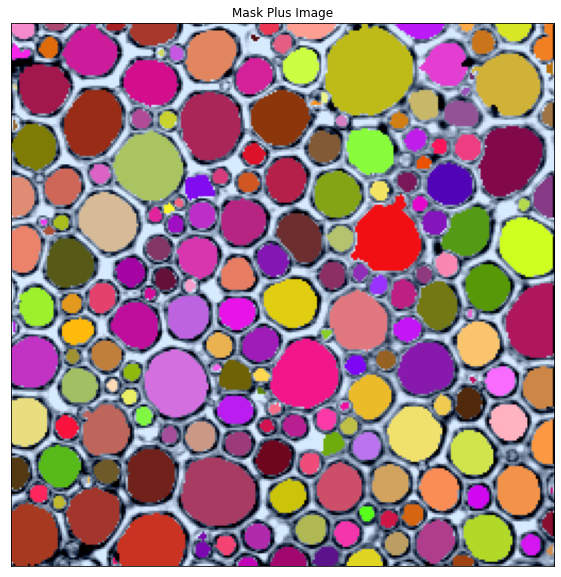

In [0]:
#@title Run this block { run: "auto" }

uploaded = files.upload()
size_of_bubbles=segment_image(uploaded,remove_bubbles_on_the_border)

For the distribution of the size of bubbles, run the block below. The historame is save as size_distribution.png

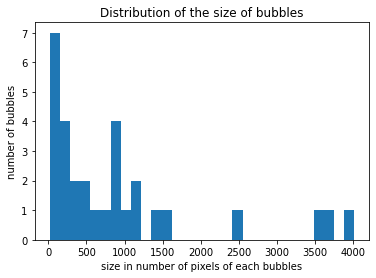

In [0]:
plt.hist(size_of_bubbles,bins = 30)
plt.xlabel('size in number of pixels of each bubbles')
plt.ylabel('number of bubbles')
plt.title('Distribution of the size of bubbles')
plt.savefig("/content/size_distribution.png")